In [1]:
import subprocess
import shlex
import json
from glob import glob
from tqdm import tqdm_notebook as tqdm
import pandas as pd

import sys
import os
sys.path.append(os.path.join(sys.path[0], '../../'))

from core.train_utils import calculate_roi, get_winner_favorite
from core.events_utils import parse_odds

In [2]:
df = pd.read_csv('./data_models/events_joined_total_08.04.2021.csv', index_col=0)
cat_cols = ['city', 'country', 'is_fight_night', 'weightCategory.id', 
              'f1_country', 'f2_country', 'f1_city', 'f2_city']

df[cat_cols] = df[cat_cols].fillna('unknown')
df = df[(df['f1_count_of_fights'] >= 1) & (df['f2_count_of_fights'] >= 1)]

df['eventDate.date'] = pd.to_datetime(df['eventDate.date'])
df['weightCategory.id'] = df['weightCategory.id'].astype('object')

df  = df[(df['eventDate.date'].dt.year == 2020) &
        ((df['type']=='straight'))]
df = df[~df['odds_difference'].isna()]

df

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,...,odds_difference,age_difference,height_difference,armSpan_difference,legSwing_difference,isHomeCity_difference,isHomeCountry_difference,isHomeTimezone_difference,winner,is_fight_night
6359,Las Vegas,USA,40.0,2020-01-18,Europe/Berlin,347,211,39796,UFC 246,1.0,...,2.32,5.0,10.16,-2.54,1.27,0.0,1.0,0.0,False,False
6360,Las Vegas,USA,106.0,2020-01-18,Europe/Berlin,404,292,39804,UFC 246,2.0,...,-1.47,3.0,-2.54,5.08,0.00,0.0,-1.0,0.0,True,False
6361,Las Vegas,USA,300.0,2020-01-18,Europe/Berlin,427,562,39805,UFC 246,3.0,...,-0.39,7.0,2.54,5.08,2.54,0.0,0.0,0.0,True,False
6362,Las Vegas,USA,300.0,2020-01-18,Europe/Berlin,407,521,39807,UFC 246,3.0,...,0.47,3.0,5.08,7.62,-0.10,0.0,1.0,0.0,False,False
6363,Las Vegas,USA,300.0,2020-01-18,Europe/Berlin,525,233,39820,UFC 246,3.0,...,-5.68,-16.0,-5.08,-10.16,5.18,0.0,0.0,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6792,Las Vegas,USA,300.0,2020-12-19,Europe/Berlin,286,3419,40352,UFC Fight Night,3.0,...,-0.23,1.0,2.54,2.54,0.00,0.0,0.0,0.0,True,True
6793,Las Vegas,USA,300.0,2020-12-19,Europe/Berlin,1995,653,40354,UFC Fight Night,3.0,...,-0.80,0.0,22.86,7.62,0.00,0.0,-1.0,0.0,False,True
6794,Las Vegas,USA,300.0,2020-12-19,Europe/Berlin,667,161,40356,UFC Fight Night,3.0,...,-0.72,6.0,-7.62,2.54,0.00,0.0,1.0,0.0,False,True
6796,Las Vegas,USA,300.0,2020-12-19,Europe/Berlin,292,244,40383,UFC Fight Night,3.0,...,-1.45,3.0,-2.54,0.00,2.54,0.0,0.0,0.0,True,True


In [3]:
events_df = pd.read_csv('../../data/0.events_raw.csv', index_col=0)
### Убираем строки, где `winnerId` не совпадает с айди ни одного из бойцов
events_df = events_df[~((events_df["winnerId"] != events_df["fighterId_1"]) & (events_df["winnerId"] != events_df["fighterId_2"]))]

events_df[["f1_odds", "f2_odds"]] = events_df[["avgOdds", "fighterId_1", "fighterId_2"]]\
            .apply(lambda row: parse_odds(row), axis=1)

events_df = events_df[~events_df['f1_odds'].isna()]
events_df = events_df.reset_index()

events_df['eventDate.date'] = pd.to_datetime(events_df['eventDate.date'])
events_df = events_df[(events_df['eventDate.date'].dt.year == 2021)]
events_df

,index,avgOdds,city,completed,country,duration,eventDate.date,eventDate.timezone,eventDate.timezone_type,fighterId_1,...,link,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_odds,f2_odds
542,0,"[{'fighterId': 2597, 'value': 2.95}, {'fighter...",Abu Dhabi,True,United Arab Emirates,300.0,2021-01-16 00:00:01,Europe/Berlin,3,2597,...,http://www.ufcstats.com/fight-details/3d903bc3...,UFC Fight Night,3.0,Asia/Dubai,4,Полулегкий вес,['DEC'],3418.0,2.95,1.43
543,0,"[{'fighterId': 240, 'value': 1.5}, {'fighterId...",Abu Dhabi,True,United Arab Emirates,300.0,2021-01-16 00:00:02,Europe/Berlin,3,240,...,http://www.ufcstats.com/fight-details/97c80f69...,UFC Fight Night,3.0,Asia/Dubai,12,Женский легчайший вес,['DEC'],3398.0,1.50,2.70
544,0,"[{'fighterId': 141, 'value': 3.37}, {'fighterI...",Abu Dhabi,True,United Arab Emirates,300.0,2021-01-16 00:00:03,Europe/Berlin,3,141,...,http://www.ufcstats.com/fight-details/3fcd53eb...,UFC Fight Night,3.0,Asia/Dubai,6,Полусредний вес,['DEC'],453.0,3.37,1.34
545,0,"[{'fighterId': 2319, 'value': 1.49}, {'fighter...",Abu Dhabi,True,United Arab Emirates,300.0,2021-01-16 00:00:04,Europe/Berlin,3,2319,...,http://www.ufcstats.com/fight-details/0165bd3c...,UFC Fight Night,3.0,Asia/Dubai,9,Тяжелый вес,['DEC'],2319.0,1.49,2.72
546,0,"[{'fighterId': 462, 'value': 1.93}, {'fighterI...",Abu Dhabi,True,United Arab Emirates,300.0,2021-01-16 00:00:05,Europe/Berlin,3,462,...,http://www.ufcstats.com/fight-details/97ad63e6...,UFC Fight Night,3.0,Asia/Dubai,12,Женский легчайший вес,['DEC'],3666.0,1.93,1.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,0,"[{'fighterId': 430, 'value': 3}, {'fighterId':...",Las Vegas,True,USA,82.0,2021-04-10 00:00:07,Europe/Berlin,3,430,...,http://www.ufcstats.com/fight-details/99829621...,UFC Fight Night,2.0,America/Los_Angeles,5,Легкий вес,['KO'],3587.0,3.00,1.42
660,0,"[{'fighterId': 288, 'value': 2.22}, {'fighterI...",Las Vegas,True,USA,300.0,2021-04-10 00:00:09,Europe/Berlin,3,288,...,http://www.ufcstats.com/fight-details/ac9a8b73...,UFC Fight Night,3.0,America/Los_Angeles,6,Полусредний вес,['DEC'],3037.0,2.22,1.71
661,0,"[{'fighterId': 552, 'value': 1.74}, {'fighterI...",Las Vegas,True,USA,288.0,2021-04-10 00:00:10,Europe/Berlin,3,552,...,http://www.ufcstats.com/fight-details/0992795f...,UFC Fight Night,1.0,America/Los_Angeles,10,Женский минимальный вес,['SUB'],600.0,1.74,2.17
662,0,"[{'fighterId': 215, 'value': 1.54}, {'fighterI...",Las Vegas,True,USA,127.0,2021-04-10 00:00:11,Europe/Berlin,3,215,...,http://www.ufcstats.com/fight-details/646eeca9...,UFC Fight Night,2.0,America/Los_Angeles,7,Средний вес,['SUB'],215.0,1.54,2.58


In [4]:
indexes = events_df.index
f1_id, f2_id, f1_odd, f2_odd, weightCategory_id, city, country, eventDate, eventName, eventTimezone = \
    events_df.loc[indexes[0], ['fighterId_1', 'fighterId_2', 'f1_odds', 'f2_odds', 'weightCategory.id',
                        'city', 'country', 'eventDate.date', 'name', 'timezone']]


f1_id, f2_id, f1_odd, f2_odd, weightCategory_id, city, country, eventDate, eventName, eventTimezone

(2597,
 3418,
 2.95,
 1.43,
 4,
 'Abu Dhabi',
 'United Arab Emirates',
 Timestamp('2021-01-16 00:00:01'),
 'UFC Fight Night',
 'Asia/Dubai')

In [7]:
Curl = f"""curl -X 'GET' \
  'http://127.0.0.1:8001/predict_fight?f1_id={f1_id}&f2_id={f2_id}&f1_odd={f1_odd}&f2_odd={f2_odd}&\
weightCategory_id={weightCategory_id}&\
city={city.replace(' ', '%20')}&\
country={country.replace(' ', '%20')}&\
event_date={str(eventDate)[:10]}&\
event_name={eventName.replace(' ', '%20')}&\
time_zone={eventTimezone}' \
  -H 'accept: application/json'"""

print(Curl)
args = shlex.split(Curl)
process = subprocess.Popen(args, shell=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
response = json.loads(stdout.decode("UTF-8"))
# v0_0 = response['y_proba_catboost_v1_0']
# v0_1 = response['y_proba_catboost_v1_1']
# v0_2 = response['y_proba_catboost_v1_2']
response

curl -X 'GET'   'http://127.0.0.1:8001/predict_fight?f1_id=2597&f2_id=3418&f1_odd=2.95&f2_odd=1.43&weightCategory_id=4&city=Abu%20Dhabi&country=United%20Arab%20Emirates&event_date=2021-01-16&event_name=UFC%20Fight%20Night&time_zone=Asia/Dubai'   -H 'accept: application/json'


{'success': True,
 'y_proba_catboost_v1_0': 0.5110534340677326,
 'y_proba_catboost_v1_1': 0.5130697956703532,
 'y_proba_catboost_v1_2': 0.509842161015506,
 'y_proba_catboost_v1_1_2020': 0.48796163965492095,
 'y_proba_catboost_v1_2_2020': 0.5072121565534351,
 'y_proba_catboost_v1_1_copy1': 0.5041415022218365,
 'y_proba_catboost_v2_1': 0.5182603755258601}

In [101]:
for ind in tqdm(events_df.index[:1]):
    f1_id, f2_id, f1_odd, f2_odd, weightCategory_id, city, country, eventDate, eventName, eventTimezone = \
        events_df.loc[ind, ['fighterId_1', 'fighterId_2', 'f1_odds', 'f2_odds', 'weightCategory.id',
                            'city', 'country', 'eventDate.date', 'name', 'timezone']]

    f1_id, f2_id, f1_odd, f2_odd, weightCategory_id, city, country, eventDate, eventName, eventTimezone
   
    Curl = f"""curl -X 'GET' \
  'http://127.0.0.1:8001/predict_fight?f1_id={f1_id}&f2_id={f2_id}&f1_odd={f1_odd}&f2_odd={f2_odd}&\
weightCategory_id={weightCategory_id}&\
city={city.replace(' ', '%20')}&\
country={country.replace(' ', '%20')}&\
event_date={str(eventDate)[:10]}&\
event_name={eventName.replace(' ', '%20')}&\
time_zone={eventTimezone}' \
  -H 'accept: application/json'"""

    args = shlex.split(Curl)
    process = subprocess.Popen(args, shell=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    response = json.loads(stdout.decode("UTF-8"))
    if response['success']:    
        v0_0 = response['y_proba_catboost_v1_0']
        v0_1 = response['y_proba_catboost_v1_1']
        v0_2 = response['y_proba_catboost_v1_2']

        events_df.at[ind, 'v0_0'] = v0_0
        events_df.at[ind, 'v0_1'] = v0_1
        events_df.at[ind, 'v0_2'] = v0_2

<ipython-input-101-c6c0a08d4cec>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ind in tqdm(events_df.index[:1]):


  0%|          | 0/1 [00:00<?, ?it/s]

In [102]:
response

{'success': True,
 'y_proba_catboost_v1_0': 0.5678792119930414,
 'values': "[6047.0, 17, 1824.0, 958.0, 5.0, 4.0, 5.0, 0.0, 1709.0, 860.0, 0.0, 13.0, 1454.0, 666.0, 203.0, 156.0, 52.0, 38.0, 1416.0, 645.0, 119.0, 87.0, 174.0, 128.0, 11, 0, 9, 3, 0.5252192982456141, 0.8, 0.5032182562902282, 0.4580467675378267, 0.7684729064039408, 0.7307692307692307, 0.4555084745762712, 0.7310924369747899, 0.735632183908046, 0.6470588235294118, 0.0, 0.5294117647058824, 0.1764705882352941, 9.505539937158922, 0.0396891020340664, 8.533156937324295, 6.608235488672069, 1.5478749793285926, 0.3770464693236315, 6.39986770299322, 0.863237969240946, 1.2700512650901274, 0.0, 0.128989581610716, 0, 2, 1898.0, 6, 411.0, 179.0, 3.0, 1.0, 0.0, 0.0, 400.0, 171.0, 0.0, 0.0, 342.0, 127.0, 45.0, 31.0, 13.0, 13.0, 353.0, 147.0, 5.0, 3.0, 42.0, 21.0, 4, 0, 3, 0, 0.4355231143552311, 0.3333333333333333, 0.4275, 0.3713450292397661, 0.6888888888888889, 1.0, 0.4164305949008499, 0.6, 0.5, 0.6666666666666666, 0.0, 0.5, 0.0, 5.658587

In [64]:
print(events_df.shape)
events_df = events_df[~events_df['v0_0'].isna()]
print(events_df.shape)

(78, 26)
(59, 26)


<AxesSubplot:>

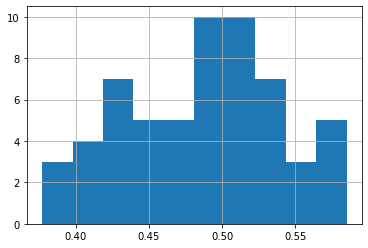

In [66]:
events_df['v0_0'].hist()

In [74]:
events_df['winner'] = events_df['winnerId'] == events_df['fighterId_1']
events_df['winner'].mean()

<ipython-input-74-9838ea2a7a3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df['winner'] = events_df['winnerId'] == events_df['fighterId_1']


0.5254237288135594

In [75]:
events_df['v0_0_pred'] = events_df['v0_0'] > 0.5
events_df['v0_1_pred'] = events_df['v0_1'] > 0.5
events_df['v0_2_pred'] = events_df['v0_2'] > 0.5

print('v0_0_pred', (events_df['v0_0_pred'] == events_df['winner']).mean())
print('v0_1_pred', (events_df['v0_1_pred'] == events_df['winner']).mean())
print('v0_2_pred', (events_df['v0_2_pred'] == events_df['winner']).mean())

v0_0_pred 0.5254237288135594
v0_1_pred 0.5932203389830508
v0_2_pred 0.5254237288135594


<ipython-input-75-41c9a4307a23>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df['v0_0_pred'] = events_df['v0_0'] > 0.5
<ipython-input-75-41c9a4307a23>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df['v0_1_pred'] = events_df['v0_1'] > 0.5
<ipython-input-75-41c9a4307a23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [79]:
events_df = get_winner_favorite(events_df)

favorite = events_df[events_df['v0_0_pred'] == events_df['favorite']]
underdog = events_df[events_df['v0_0_pred'] != events_df['favorite']]

calculate_roi(events_df, pred_col='v0_0_pred')
calculate_roi(favorite, pred_col='v0_0_pred')
calculate_roi(underdog, pred_col='v0_0_pred')

/home/nikolay/workspace/UFC_betting/UFC_3.0/Notebooks/Catboost_v1_2/../../core/train_utils.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['favorite'] = favorite_list


  0%|          | 0/59 [00:00<?, ?it/s]

{'accuracy:': 0.5254237288135594,
 'bets_count:': 59,
 'finish_bank:': -242.0,
 'roi:': -4.101694915254237}


  0%|          | 0/39 [00:00<?, ?it/s]

{'accuracy:': 0.5641025641025641,
 'bets_count:': 39,
 'finish_bank:': -577.0,
 'roi:': -14.794871794871796}


  0%|          | 0/20 [00:00<?, ?it/s]

{'accuracy:': 0.45, 'bets_count:': 20, 'finish_bank:': 335.0, 'roi:': 16.75}


In [80]:
favorite = events_df[events_df['v0_1_pred'] == events_df['favorite']]
underdog = events_df[events_df['v0_1_pred'] != events_df['favorite']]

calculate_roi(events_df, pred_col='v0_1_pred')
calculate_roi(favorite, pred_col='v0_1_pred')
calculate_roi(underdog, pred_col='v0_1_pred')

  0%|          | 0/59 [00:00<?, ?it/s]

{'accuracy:': 0.5932203389830508,
 'bets_count:': 59,
 'finish_bank:': -430.0,
 'roi:': -7.288135593220339}


  0%|          | 0/53 [00:00<?, ?it/s]

{'accuracy:': 0.5849056603773585,
 'bets_count:': 53,
 'finish_bank:': -677.0,
 'roi:': -12.773584905660377}


  0%|          | 0/6 [00:00<?, ?it/s]

{'accuracy:': 0.6666666666666666,
 'bets_count:': 6,
 'finish_bank:': 246.99999999999997,
 'roi:': 41.166666666666664}


In [81]:
favorite = events_df[events_df['v0_2_pred'] == events_df['favorite']]
underdog = events_df[events_df['v0_2_pred'] != events_df['favorite']]

calculate_roi(events_df, pred_col='v0_2_pred')
calculate_roi(favorite, pred_col='v0_2_pred')
calculate_roi(underdog, pred_col='v0_2_pred')

  0%|          | 0/59 [00:00<?, ?it/s]

{'accuracy:': 0.5254237288135594,
 'bets_count:': 59,
 'finish_bank:': -242.0,
 'roi:': -4.101694915254237}


  0%|          | 0/39 [00:00<?, ?it/s]

{'accuracy:': 0.5641025641025641,
 'bets_count:': 39,
 'finish_bank:': -577.0,
 'roi:': -14.794871794871796}


  0%|          | 0/20 [00:00<?, ?it/s]

{'accuracy:': 0.45, 'bets_count:': 20, 'finish_bank:': 335.0, 'roi:': 16.75}


In [118]:
f1_id, f2_id, f1_odd, f2_odd, weightCategory_id, city, country, eventDate, eventName, eventTimezone

(3527,
 92,
 1.83,
 2.05,
 4,
 'Las Vegas',
 'USA',
 Timestamp('2021-02-20 00:00:00'),
 'UFC Fight Night',
 'America/Los_Angeles')

In [119]:
str(eventDate)[:10]

'2021-02-20'

In [122]:
Curl = f"""curl -X 'GET' \
'http://127.0.0.1:8001/predict_fight?f1_id={f1_id}&f2_id={f2_id}&f1_odd={f1_odd}&f2_odd={f2_odd}&\
weightCategory_id={weightCategory_id}&\
city={city.replace(' ', '%20')}&\
country={country.replace(' ', '%20')}&\
event_date={str(eventDate)[:10]}&\
event_name={eventName.replace(' ', '%20')}&\
time_zone={eventTimezone}' \
-H 'accept: application/json'"""

args = shlex.split(Curl)
process = subprocess.Popen(args, shell=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
response = json.loads(stdout.decode("UTF-8"))

response

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [56]:
stdout.decode("UTF-8")

''

In [18]:
fighters_df = pd.read_csv("./data_models/fighters_df.csv", index_col=0)
fighters_df

,name,weight,height,armSpan,legSwing,weightCategory.id,weightCategory.name,dateOfBirth,country,city,timezone
id,,,,,,,,,,,
1,Tanner Boser,115.67,187.96,190.50,101.70,9,Тяжелый вес,1991-08-02,Canada,Bonnyville,America/Edmonton
2,Giacomo Lemos,112.04,190.50,190.50,101.70,9,Тяжелый вес,1989-06-23,Brazil,NaN,America/Sao_Paulo
3,Shamil Abdurakhimov,106.59,190.50,193.04,105.41,9,Тяжелый вес,1981-09-02,Dagestan,Makhachkala,Europe/Moscow
4,Klidson Abreu,92.99,182.88,187.96,101.70,8,Полутяжелый вес,1992-12-24,Brazil,Manaus,America/Manaus
5,Yoshihiro Akiyama,77.11,177.80,190.50,106.68,6,Полусредний вес,1975-07-29,Japan,Ikuno,Asia/Tokyo
...,...,...,...,...,...,...,...,...,...,...,...
3673,Rinat Fakhretdinov,83.91,182.88,182.88,101.70,14,Не определена,1991-09-28,NaN,NaN,NaN
3674,Carlston Harris,77.11,182.88,182.88,101.70,14,Не определена,1987-07-09,NaN,NaN,NaN
3675,Askar Askar,65.77,170.18,170.18,101.70,14,Не определена,1994-08-19,NaN,NaN,NaN


In [33]:
246 in fighters_df.index

True

In [ ]:
246,
227